In [ ]:
##Kaggle functionality for loading data; Note that you have to use your kaggle API token (see the link above):
# !pip install opendatasets
# !pip install -q kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !ls ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c paddy-disease-classification

# #Unpack data:
# !mkdir paddy-disease
# !unzip paddy-disease-classification.zip -d paddy-disease

# #Install LightAutoML, Pandas and torch EfficientNet:
# !pip install -U lightautoml[cv] #[cv] is for installing CV tasks functionality
# !pip install efficientnet-pytorch==0.7.0
# !pip install -U pandas

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.image_presets import TabularCVAutoML
from lightautoml.tasks import Task

In [8]:
np.random.seed(42)
torch.set_num_threads(2)

In [3]:
INPUT_DIR = './paddy-disease/'

In [20]:
train_data = pd.read_csv(INPUT_DIR + 'train.csv')
print(train_data.shape)
train_data.head()

(10407, 4)


image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

Добавляем колонку с путями картинок.



In [21]:
%%time

train_data['path'] = INPUT_DIR + 'train_images/' + train_data['label'] + '/' + train_data['image_id']
train_data.head()

CPU times: user 6.4 ms, sys: 1.08 ms, total: 7.48 ms
Wall time: 10.8 ms


image_id                  label variety  age  \
0  100330.jpg  bacterial_leaf_blight   ADT45   45   
1  100365.jpg  bacterial_leaf_blight   ADT45   45   
2  100382.jpg  bacterial_leaf_blight   ADT45   45   
3  100632.jpg  bacterial_leaf_blight   ADT45   45   
4  101918.jpg  bacterial_leaf_blight   ADT45   45   

                                                path  
0  ./paddy-disease/train_images/bacterial_leaf_bl...  
1  ./paddy-disease/train_images/bacterial_leaf_bl...  
2  ./paddy-disease/train_images/bacterial_leaf_bl...  
3  ./paddy-disease/train_images/bacterial_leaf_bl...  
4  ./paddy-disease/train_images/bacterial_leaf_bl...

# Создание модели

In [22]:
task = Task('multiclass')

In [23]:
roles = {
    'target': 'label',
    'path': ['path'],
    'drop': ['variety', 'age'],
    'group': 'image_id'
}

automl = TabularCVAutoML(task=task,
                         timeout=3600,
                         cpu_limit=2,
                         reader_params={'cv': 5, 'random_state': 42})

# Обучение AutoML

In [24]:
%%time 

oof_pred = automl.fit_predict(train_data, roles=roles, verbose=3)

[00:22:04] Stdout logging level is INFO3.
[00:22:04] Task: multiclass

[00:22:04] Start automl preset with listed constraints:
[00:22:04] - time: 3600.00 seconds
[00:22:04] - CPU: 2 cores
[00:22:04] - memory: 16 GB

[00:22:04] Train data shape: (10407, 5)

[00:22:04] Layer 1 train process start. Time left 3599.92 secs


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


100%|██████████| 82/82 [01:12<00:00,  1.13it/s]


[00:23:22] Feature path transformed
[00:23:23] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[00:23:23] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[00:23:24] Linear model: C = 1e-05 score = -1.6055354153555599
[00:23:26] Linear model: C = 5e-05 score = -1.2046568036268392
[00:23:27] Linear model: C = 0.0001 score = -1.037389513346396
[00:23:29] Linear model: C = 0.0005 score = -0.7044149751456502
[00:23:30] Linear model: C = 0.001 score = -0.5902450302584152
[00:23:32] Linear model: C = 0.005 score = -0.4066410315283329
[00:23:33] Linear model: C = 0.01 score = -0.3638987668583561
[00:23:35] Linear model: C = 0.05 score = -0.33720491329123614
[00:23:37] Linear model: C = 0.1 score = -0.34965034073679147
[00:23:38] Linear model: C = 0.5 score = -0.4099675468180123
[00:23:38] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[00:23:40] Linear model: C = 1e-05 score = -1.6060200854047824
[00:23:42] Linear model: C = 5e-05 score = -1.207522436

[00:27:32] 0:	learn: 2.2653420	test: 2.2654054	best: 2.2654054 (0)	total: 43.1ms	remaining: 2m 9s
[00:28:00] bestTest = 0.2690028338
[00:28:00] bestIteration = 2999
[00:28:00] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[00:28:00] 0:	learn: 2.2668477	test: 2.2670016	best: 2.2670016 (0)	total: 10.7ms	remaining: 32s
[00:28:29] bestTest = 0.2651534201
[00:28:29] bestIteration = 2999
[00:28:29] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[00:28:29] 0:	learn: 2.2656042	test: 2.2664293	best: 2.2664293 (0)	total: 10.8ms	remaining: 32.5s
[00:28:57] bestTest = 0.2952104901
[00:28:57] bestIteration = 2999
[00:28:57] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[00:28:58] 0:	learn: 2.2637109	test: 2.2660245	best: 2.2660245 (0)	total: 10.2ms	remaining: 30.6s
[00:29:25] bestTest = 0.3013892315
[00:29:25] bestIteration = 2999
[00:29:26] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = -0.28268724848507215
[00:29:26] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed
[00:29:26] Time left 3158.02 secs

[00:29:26] Layer 1 training completed.

[00:29:26] Blending: optimization starts with equal weights and score -0.2427339312736738
[00:29:26] Blending: iteration 0: score = -0.24027219374387357, weights = [0.37110832 0.62889165]
[00:29:26] Blending: iteration 1: score = -0.24027219374387357, weights = [0.37110832 0.62889165]
[00:29:26] Blending: no score update. Terminated

[00:29:26] Automl preset training completed in 442.16 seconds

[00:29:26] Model description:
Final prediction for new objects (level 0) = 
	 0.37111 * (4 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.62889 * (4 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 

CPU

Посмотрим на out-of-fold предсказания модели. В случае мультиклассовой классификации, ```LightAutoML``` возвращает вероятности классов в качестве предсказаний.

In [26]:
preds = train_data[['image_id', 'label']]
for i in range(10):
    preds['pred_' + str(i)] = oof_pred.data[:,i]
    
preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


image_id                  label    pred_0    pred_1    pred_2  \
0      100330.jpg  bacterial_leaf_blight  0.020604  0.360138  0.402973   
1      100365.jpg  bacterial_leaf_blight  0.041199  0.338623  0.044106   
2      100382.jpg  bacterial_leaf_blight  0.085126  0.202267  0.302371   
3      100632.jpg  bacterial_leaf_blight  0.007831  0.772487  0.010031   
4      101918.jpg  bacterial_leaf_blight  0.021298  0.153516  0.039869   
...           ...                    ...       ...       ...       ...   
10402  107607.jpg                 tungro  0.008465  0.020844  0.000934   
10403  107811.jpg                 tungro  0.001228  0.202364  0.016311   
10404  108547.jpg                 tungro  0.001525  0.039695  0.002633   
10405  110245.jpg                 tungro  0.006035  0.031850  0.000466   
10406  110381.jpg                 tungro  0.154793  0.048842  0.078347   

         pred_3    pred_4    pred_5    pred_6    pred_7        pred_8  \
0      0.003394  0.067288  0.028710  0.001623  0.115230  1.642598e-05   
1      0.000181  0.018184  0.055776  0.000560  0.501299  5.160815e-05   
2      0.007710  0.022013  0.009413  0.000351  0.370369  3.647954e-04   
3      0.000932  0.132978  0.002223  0.000157  0.073216  1.046456e-04   
4      0.000104  0.030173  0.000710  0.000327  0.754004  1.029202e-07   
...         ...       ...       ...       ...       ...           ...   
10402  0.000220  0.912799  0.001032  0.055698  0.000005  3.641807e-06   
10403  0.007188  0.682410  0.003198  0.084703  0.002256  3.296992e-04   
10404  0.001502  0.943956  0.001407  0.008925  0.000158  1.907664e-04   
10405  0.000747  0.788912  0.004558  0.165864  0.001532  1.703711e-05   
10406  0.006539  0.668497  0.007989  0.033110  0.001795  7.972174e-05   

             pred_9  
0      2.509150e-05  
1      1.876510e-05  
2      1.590227e-05  
3      4.053696e-05  
4      1.880157e-07  
...             ...  
10402  1.737569e-07  
10403  1.273677e-05  
10404  7.666896e-06  
10405  1.954897e-05  
10406  8.399358e-06  

[10407 rows x 12 columns]

Найдем классы с наибольшими вероятностями.

In [27]:
OOFs = np.argmax(preds[['pred_' + str(i) for i in range(10)]].values, axis = 1)
OOFs

array([2, 7, 7, ..., 4, 4, 4])

Посчитаем точность предсказаний.

In [28]:
accuracy = (OOFs == preds['label'].map(automl.reader.class_mapping)).mean()
print(f'Out-of-fold accuracy: {accuracy}')

Out-of-fold accuracy: 0.9420582300374748


Чтобы оценить качество предсказаний, можно также посмотреть на матрицу ошибок.

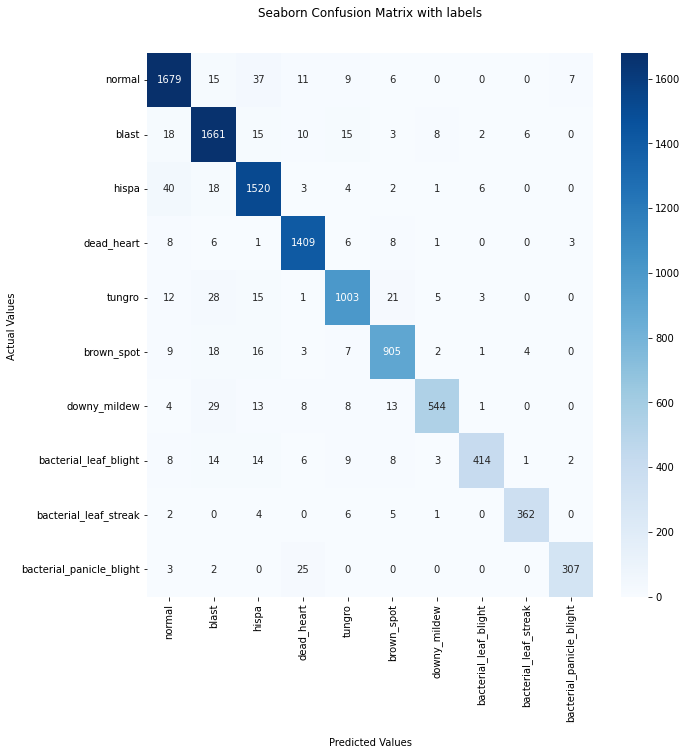

In [29]:
cf_matrix = confusion_matrix(preds['label'].map(automl.reader.class_mapping), OOFs)

plt.figure(figsize = (10, 10))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = 'd')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

inverse_class_mapping = {y: x for x,y in automl.reader.class_mapping.items()}
labels = [inverse_class_mapping[i] for i in range(len(inverse_class_mapping))]
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels, rotation = 0)

plt.show()